In [6]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
import os

In [7]:
load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [10]:
llm = ChatGroq(model="gemma2-9b-it")

In [11]:
from pydantic import BaseModel, Field
class SentimentSchema(BaseModel):
    sentiment : Literal['positive','negative'] = Field(description="Sentiement of the review")


In [12]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [15]:

structured_model = llm.with_structured_output(SentimentSchema)
structured_model2 = llm.with_structured_output(DiagnosisSchema)

In [20]:
structured_model.invoke("What is the sentiment of the following review - The software too good")

SentimentSchema(sentiment='positive')

In [21]:
class ReviewState(TypedDict):

    review : str
    sentiment: Literal['positive','negative']
    diagnosis: dict
    response : str    

In [24]:
def find_sentiment(state: ReviewState):

    prompt = f'For the following review find out the sentiment \n {state["review"]}'
    sentiment = structured_model.invoke(prompt)

    return {'sentiment': sentiment}

def check_sentiment(state: ReviewState)->Literal['positive_response','run_diagnosis']:

    if state['sentiment'] == 'positive' :
        return 'positive_response'
    else:
        return 'run_diagnosis'

def positive_response(state: ReviewState):
    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website."""
    response = llm.invoke(prompt).content
    return {'response': response}

def run_diagnosis(state:ReviewState):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    res = structured_model2.invoke(prompt)
    return {'diagnosis': res.model_dump()}

def negative_response(state:ReviewState):

    diagnosis = state['diagnosis']
    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    res = llm.invoke(prompt).content
    return {'response':res}




In [32]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_response', END)

graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()

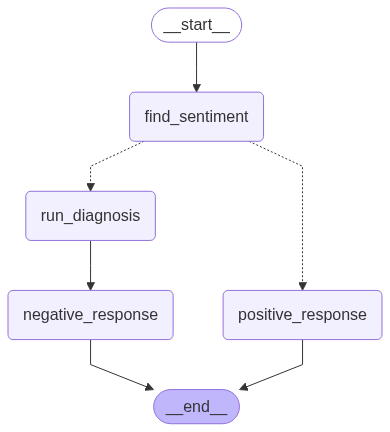

In [33]:
workflow

In [34]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': SentimentSchema(sentiment='negative'),
 'diagnosis': {'issue_type': 'Bug', 'tone': 'angry', 'urgency': 'high'},
 'response': "Hi [User Name],\n\nI understand you're frustrated with the bug you're experiencing, and I'm really sorry for the inconvenience it's causing. \n\nI see you've marked this as high urgency, and I want to assure you that I'm doing everything I can to help resolve it as quickly as possible. \n\nTo get started, could you please provide me with some more details about the bug? For example:\n\n* **What exactly is happening?**\n* **What were you doing when the bug occurred?**\n* **Can you reproduce the bug consistently? If so, how?**\n* **What steps have you already taken to try and fix it?**\n\nThe more information 